In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 85.8 MB/s eta 0:00:00


In [ ]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Asking for the BASE_DIR from the user.

In [ ]:
while True:
  BASE_DIR = str(input("Enter the base directory: "))

  # if BASE_DIR exists
  if os.path.isdir(BASE_DIR):

    # Checking if multiple paths inside it exists or not including train folder,
    # train_target folder, test folder, and test_target folder

    TRAIN_PATH = os.path.join(BASE_DIR, 'train')
    if not os.path.isdir(TRAIN_PATH):
      print(f'Train directory not found.')
      print()
      continue

    TRAIN_MASK_PATH = os.path.join(BASE_DIR, 'train_target')
    if not os.path.isdir(TRAIN_MASK_PATH):
      print(f'Train Test directory not found.')
      print()
      continue

    TEST_PATH = os.path.join(BASE_DIR, 'test')
    if not os.path.isdir(TEST_PATH):
      print(f'Test directory not found.')
      print()
      continue

    TEST_MASK_PATH = os.path.join(BASE_DIR, 'test_target')
    if not os.path.isdir(TEST_MASK_PATH):
      print(f'Test Mask directory not found.')
      print()
      continue

    print(f'Base directory found.')
    print()
    break
  else:
    print(f'Base directory not found.')
    print()

Enter the base directory: /content/drive/MyDrive/Raj_RGB_Data/Raj_Rwanda_RGB_Data/Split_Tif_Inputs_Example
Base directory found.



Reading the data from the respective folders.

In [ ]:
# Getting the number of images withing the directory
image_names = glob.glob(os.path.join(TRAIN_PATH, '*.tif'))
image_names.sort()
image_names_len = len(image_names)

# Getting the number of masks within the directory
mask_names = glob.glob(os.path.join(TRAIN_MASK_PATH, '*.tif'))
mask_names.sort()
mask_names_len = len(mask_names)

In [ ]:
# Making sure that the length of the features is same as the length of labels.
are_same_length = True
if image_names_len != mask_names_len:
  are_same_length = False
  print(f'Image and mask names are not the same length.')
  print('Please wait for few minutes before running this file after diconnecting and connecting again.')
  print()
else:
  print(f'Image and mask names are the same length.')
  print()

Image and mask names are the same length.



In [ ]:
# Checking if the number of features are same as number of labels. If they are
# not same, then this loop will continue forever, stopping the future processes.
while True:
  if not are_same_length:
    print(f'Image and mask names are not the same length.')
    print('Please wait for few minutes before running this file after diconnecting and connecting again.')
    print('This loop will continue until you run this notebook again.')
    print()
  else:
    print(f'Image and mask names are the same length.')
    print(f'Hence, this loop will break')
    break

Image and mask names are the same length.
Hence, this loop will break


In [ ]:
images_np = [rasterio.open(img).read() for img in image_names]

In [ ]:
images = np.array(images_np).transpose(0, 2, 3, 1)

In [ ]:
print(f"The number of samples training x samples available are {len(images)}")
print(f"The shape of each sample is {images[0].shape}")

The number of samples training x samples available are 38
The shape of each sample is (256, 256, 3)


In [ ]:
masks_np = [rasterio.open(img).read() for img in mask_names]

In [ ]:
masks = np.array(masks_np).transpose(0,2,3,1)


In [ ]:
print(f"The number of samples training y samples available are {len(masks)}")
print(f"The shape of each sample is {masks[0].shape}")

The number of samples training y samples available are 38
The shape of each sample is (256, 256, 1)


In [ ]:
masks[masks != 0] = 1

Graphing randomly 15 charts showing planet images or the features or the corresponding labels.

In [ ]:
import random
import cv2
for i in range(15):
  # importing the random module

  j = random.randint(0,len(masks)-1)
  plt.figure(figsize=(16, 8))

  plt.subplot(231)
  plt.title('Sentinel Image')
  plt.imshow(images[j,:,:,0])

  plt.subplot(232)
  plt.title('JB Product')
  plt.imshow(masks[j,:,:,0])

Output hidden; open in https://colab.research.google.com to view.

Splitting the data into test and training data.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size = 0.10)

In [ ]:
print(f"The number of features samples for training are {X_train.shape[0]}")
print(f"The number of labels samples for training are {y_train.shape[0]}")

The number of features samples for training are 34
The number of labels samples for training are 34


In [ ]:
print(f"The number of features samples for testing are {X_test.shape[0]}")
print(f"The number of labels samples for training are {y_test.shape[0]}")

The number of features samples for testing are 4
The number of labels samples for training are 4


### Training the Model

From here, we will train the U-Net model. The parameters are hardcoded, you can change them accordingly.

In [ ]:
# Specify model training parameters.
BATCH_SIZE = 16
EPOCHS = 100
OPTIMIZER = 'Adam'
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']
BANDS = X_train.shape[3]

In [ ]:
# The early syopping prevents the model from over-fitting.
# You can change the parameters accordingly.
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.14.0


In [ ]:
# This is the U-Net model and its information is written in the paper.
# You can read the paper and change the model as needed.
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import optimizers

def conv_block(input_tensor, num_filters):
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	return encoder

def encoder_block(input_tensor, num_filters):
	encoder = conv_block(input_tensor, num_filters)
	encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
	return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
	decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
	decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	return decoder

def get_model():
	inputs = layers.Input(shape=[None, None, BANDS]) # 256
	encoder0_pool, encoder0 = encoder_block(inputs, 32) # 128
	encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64
	encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
	encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16
	encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) # 8
	center = conv_block(encoder4_pool, 1024) # center
	decoder4 = decoder_block(center, encoder4, 512) # 16
	decoder3 = decoder_block(decoder4, encoder3, 256) # 32
	decoder2 = decoder_block(decoder3, encoder2, 128) # 64
	decoder1 = decoder_block(decoder2, encoder1, 64) # 128
	decoder0 = decoder_block(decoder1, encoder0, 32) # 256
	outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

	model = models.Model(inputs=[inputs], outputs=[outputs])

	model.compile(
		optimizer=optimizers.get(OPTIMIZER),
		loss=losses.get(LOSS),
		metrics=[metrics.get(metric) for metric in METRICS])

	return model

In [ ]:
# Initialize the model
m = get_model()
m.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalization[0][0

In [ ]:
# Start training the model
m.fit(X_train, y_train,
      batch_size = BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(X_test, y_test),
      callbacks=callbacks)

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.1528 - root_mean_squared_error: 0.3909
Epoch 1: val_loss did not improve from 0.25961
3/3 [==============================] - 1s 283ms/step - loss: 0.1528 - root_mean_squared_error: 0.3909 - val_loss: 0.3880 - val_root_mean_squared_error: 0.6229 - lr: 1.0000e-05
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.1532 - root_mean_squared_error: 0.3914
Epoch 2: val_loss did not improve from 0.25961
3/3 [==============================] - 1s 264ms/step - loss: 0.1532 - root_mean_squared_error: 0.3914 - val_loss: 0.3305 - val_root_mean_squared_error: 0.5749 - lr: 1.0000e-05
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.1528 - root_mean_squared_error: 0.3909
Epoch 3: val_loss did not improve from 0.25961
3/3 [==============================] - 1s 263ms/step - loss: 0.1528 - root_mean_squared_error: 0.3909 - val_loss: 0.2800 - val_root_mean_squared_error: 0.5291 - lr: 1.0000e-05
Epoch 4

### Save the model.

It is always better to save the model because many times the notebook runs out of the memory because of the next steps.

It is not a big problem if the memory runs out.

In [ ]:
# Getting the model path to save it.
print('\033[1mImportant Notes - \033[0m')
print('1.) It is not a problem if the path exists or not because Tensorflow creates a path even if it doesnot exists.')
print('2.) Make sure that the path is valid, i.e., it is in the google colab and does not contains silly mistakes.')
print('3.) Please check within few minutes if the model has been saved or not by looking at the directory in the drive.')
print()
while True:
  model_output_path = (str(input("Enter the model output path: ")))
  if model_output_path == '':
    print('Please enter a valid path.')
    print()
  else:
    break

Important Notes - 
1.) It is not a problem if the path exists or not because Tensorflow creates a path even if it doesnot exists.
2.) Make sure that the path is valid, i.e., it is in the google colab and does not contains silly mistakes.
3.) Please check within few minutes if the model has been saved or not by looking at the directory in the drive.

Enter the model output path: /content/drive/MyDrive/Raj_RGB_Data/Raj_Rwanda_RGB_Data


In [ ]:
# Getting the model name to be saved
while True:
  model_name = (str(input("Enter the model name: ")))
  if model_name == '':
    print('Please enter a valid model name.')
    print()
  else:
    break

Enter the model name: Sentinel_Pipeline_Example_Rwanda


In [ ]:
# Creating the full path
model_save_full_path = os.path.join(model_output_path, model_name)

In [ ]:
# Asking for the users to save the model
print('The model will be saved at - ')
print(f'\033[1m{model_save_full_path}\033[0m')
print()

while True:
  want_to_continue =  str(input('Do you want to continue? (y/n): '))
  # If user want to save the model, it will be saved.
  if want_to_continue == 'y':
    print()
    print('Saving the model...')
    m.save(model_save_full_path)
    print('Model saved.')
    break
  elif want_to_continue == 'n':
    print('Model not saved.')
    print('You can change the names above or any other change you want to make.')
    break
  else:
    print('Please enter a valid input (y or n).')
    print()

The model will be saved at - 
/content/drive/MyDrive/Raj_RGB_Data/Raj_Rwanda_RGB_Data/Sentinel_Pipeline_Example_Rwanda

Do you want to continue? (y/n): y

Saving the model...
Model saved.


### Looking at the model through visualization

Now, as our model is saved, we can apply prediction on our test data and the validation data.

Predicting the validation data.

1/1 [==============================] - 2s 2s/step


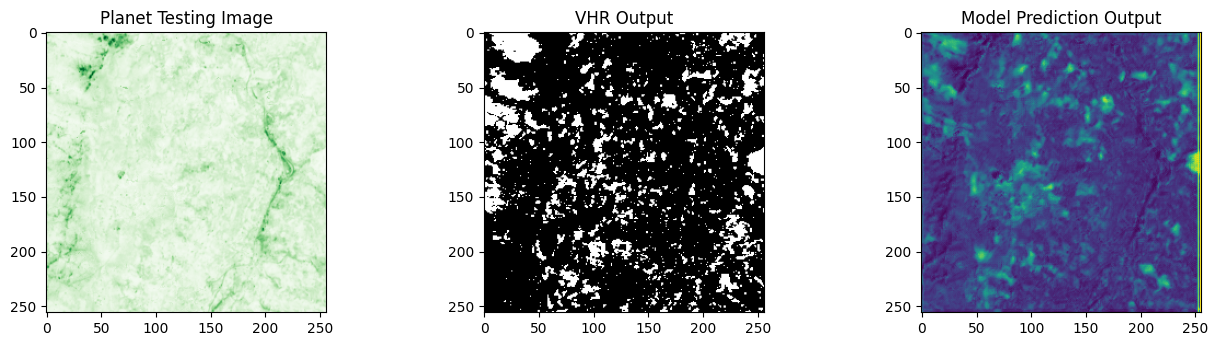

1/1 [==============================] - 0s 21ms/step


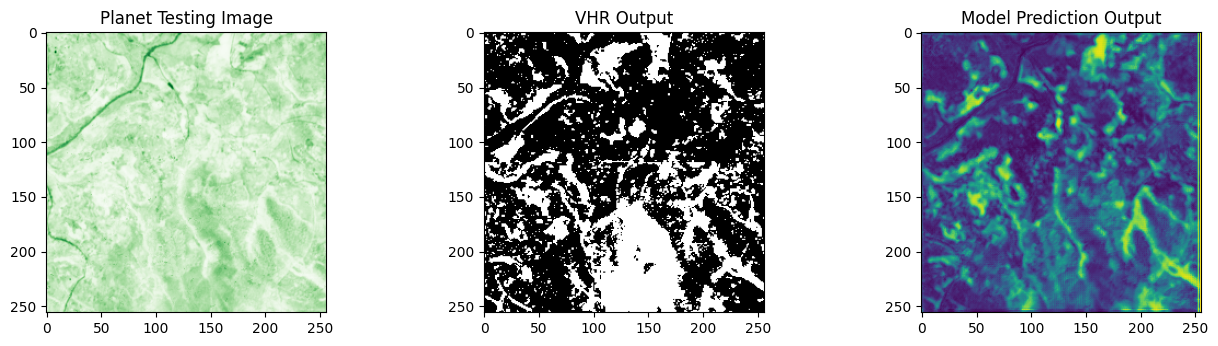

1/1 [==============================] - 0s 21ms/step


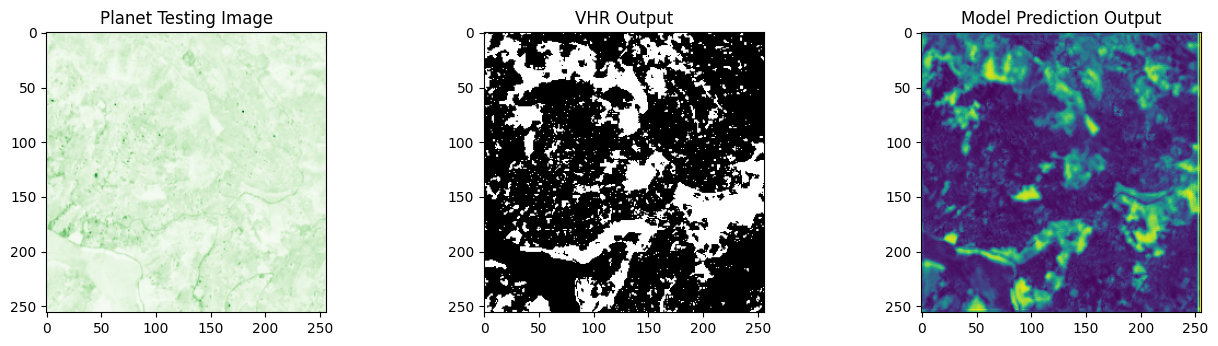

1/1 [==============================] - 0s 28ms/step


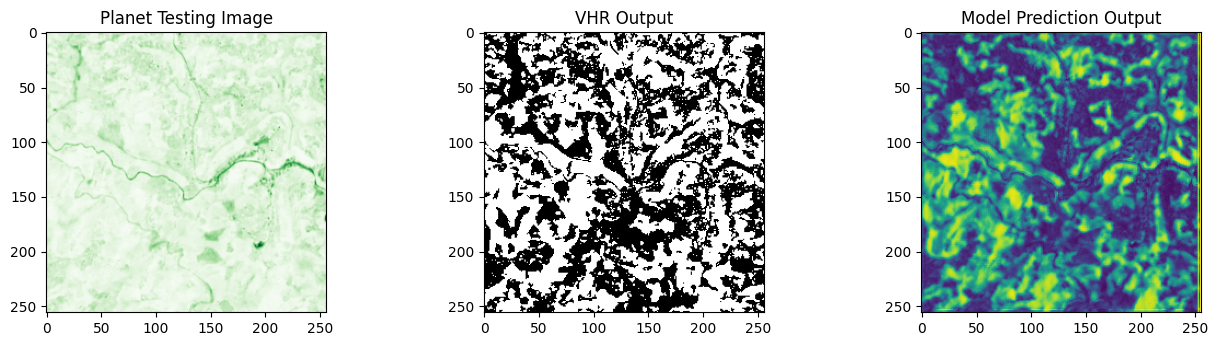

In [ ]:
# This loop breaks after 50 prediction to make sure that the ram doesnot disconnect.
# If you want to change the number of predictions, please change i_validation_break.

i = 0
i_validation_break = 50

for test_img_number, test_img in enumerate(X_test):
  cmap = plt.cm.Greens

  ground_truth=y_test[test_img_number]
  test_img_input=np.expand_dims(test_img, 0)

  # Applying the model on the validation data.
  prediction = (m.predict(test_img_input)[0,:,:,0])

  plt.figure(figsize=(16, 8))
  plt.subplot(231)
  plt.title('Planet Testing Image')
  plt.imshow(test_img[:,:,0], cmap=cmap)
  plt.subplot(232)
  plt.title('VHR Output')
  plt.imshow(ground_truth[:,:,0], cmap='gray')
  plt.subplot(233)
  plt.title('Model Prediction Output')
  plt.imshow(prediction)
  # rasterio.plot.show_hist(prediction)


  plt.show()

  i += 1
  if i == i_validation_break:
    break

Predicting the testing data

In [ ]:
# Loading the images from the test folder
testimage_names = glob.glob(os.path.join(TEST_PATH,"*.tif"))
testimage_names.sort()

testimages = []
for img in testimage_names:
  testimages.append(rasterio.open(img).read())

testimages = np.array(testimages).transpose(0,2,3,1)

In [ ]:
# Loading the masks from test_target folder
testmask_names = glob.glob(os.path.join(TEST_MASK_PATH,"*.tif"))
testmask_names.sort()

testmasks = []
for mask in testmask_names:
  testmasks.append(rasterio.open(mask).read())

testmasks = np.array(testmasks).transpose(0,2,3,1)

In [ ]:
# This loop breaks after 60 prediction to make sure that the ram doesnot disconnect.
# If you want to change the number of predictions, please change i_testing_break.

i = 0
i_testing_break = 60

# Applying the model on the testing data.
for test_img_number, test_img in enumerate(testimages):
  cmap = plt.cm.Greens

  real_truth = testmasks[test_img_number]
  test_img_input=np.expand_dims(test_img, 0)
  # print(test_img_input.shape)
  prediction = (m.predict(test_img_input)[0,:,:,0])
  # print(prediction.shape)

  plt.figure(figsize=(16, 8))
  plt.subplot(231)
  plt.title('Planet Testing Image')
  plt.imshow(test_img[:,:,2])
  plt.subplot(232)
  plt.title('VHR Output')
  plt.imshow(real_truth[:,:,0])
  plt.subplot(233)
  plt.title('Prediction on Planet Test Image')
  plt.imshow(prediction)

  plt.show()

  i += 1
  if i > i_testing_break:
    break

Output hidden; open in https://colab.research.google.com to view.